In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

## Домашнее Задание  №3

### Обработка текстов. Линейная классификация.

В задании вам предоставлены реальные текстовые данные. 

Необходимо построить алгоритм, который будет по тексту документа определять тип источника:
 - Микроблоги
 - Новости
 - Отзывы
 - Форумы
 - Блоги
 - Видео
 - Мессенджеры

## Часть 1. Работа с текстовыми данными

 ### 1. Исследование данных

[2 балла]

Считаем данные

In [2]:
D = pd.read_csv('texts_dataset.csv', sep=';', index_col=0, low_memory=False)

In [3]:
D.head()

,Дата,ID сообщения,Заголовок,Текст,Дублей,Тип источника
0,27.04.2019 13:18,1396238,NaN,"-Здравствуйте, тинькофф банк\n-Мать твою ебал\...",1.0,Микроблоги
1,27.04.2019 13:15,1396239,NaN,Почему Немагия сделала обзор на Тинькова? #нем...,1.0,Микроблоги
2,27.04.2019 13:10,1396248,Forbes назвал самые экстравагантные инвестиции...,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 57 ...",2.0,Новости
3,27.04.2019 13:06,1396243,Forbes назвал самые экстравагантные инвестиции...,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 44 ...",2.0,Новости
4,27.04.2019 13:03,1396186,Тинькофф Страхование: Не купить полис без подп...,Первый отзыв без оценки:&nbsp;\nhttps://www.ba...,1.0,Отзывы


Далее будем использовать лишь поля  "Текст", "Тип источника"

In [4]:
D = D[[ "Текст", "Тип источника"]]

In [5]:
D.head()

,Текст,Тип источника
0,"-Здравствуйте, тинькофф банк\n-Мать твою ебал\...",Микроблоги
1,Почему Немагия сделала обзор на Тинькова? #нем...,Микроблоги
2,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 57 ...",Новости
3,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 44 ...",Новости
4,Первый отзыв без оценки:&nbsp;\nhttps://www.ba...,Отзывы


In [6]:
for i in D['Тип источника'].unique():
    print (i)

Микроблоги
Новости
Отзывы
Форумы
Блоги
Видео
Мессенджеры
nan


In [7]:
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200206 entries, 0 to 200205
Data columns (total 2 columns):
Текст            199578 non-null object
Тип источника    199993 non-null object
dtypes: object(2)
memory usage: 4.6+ MB


Удалим объекты с пропусками

In [8]:
D.dropna(axis = 0, inplace=True)

#### 1.1 Выведите среднюю длину текстов в каждом классе. Что можно сказать о данных? Что можно сказать о каждом классе?

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
D['Длины строк'] = D['Текст'].str.len()
D.groupby('Тип источника')['Длины строк'].mean()

Тип источника
Блоги          3490.849468
Видео           905.184790
Мессенджеры     943.782397
Микроблоги      170.061410
Новости        2602.342321
Отзывы          550.478565
Форумы          462.227363
Name: Длины строк, dtype: float64

В среднем в классе "блог" самые длинные тексты, а в классе "микроблог" - самые короткие. "Видео" и "мессенджеры" практически не отличаются, так же как "отзывы" и "форумы"

#### 1.2 Приведите тексты к нижнему регистру и токенезируйте их

используйте word_tokenize из nltk.tokenize

In [11]:
import nltk
import re
import tqdm
from nltk.stem.lancaster import LancasterStemmer

In [12]:
D.index=np.arange(D.shape[0])

In [13]:
D['Текст'] = D['Текст'].str.lower()

In [14]:
tokens = D["Текст"].apply(nltk.word_tokenize)
D["Токены"] = tokens

In [15]:
D.head()

,Текст,Тип источника,Длины строк,Токены
0,"-здравствуйте, тинькофф банк\n-мать твою ебал\...",Микроблоги,65,"[-здравствуйте, ,, тинькофф, банк, -мать, твою..."
1,почему немагия сделала обзор на тинькова? #нем...,Микроблоги,108,"[почему, немагия, сделала, обзор, на, тинькова..."
2,"13:01, 27.04.2019 \n\nподелиться:\n\n \n 57 ...",Новости,3312,"[13:01, ,, 27.04.2019, поделиться, :, 57, forb..."
3,"13:01, 27.04.2019 \n\nподелиться:\n\n \n 44 ...",Новости,3312,"[13:01, ,, 27.04.2019, поделиться, :, 44, forb..."
4,первый отзыв без оценки:&nbsp;\nhttps://www.ba...,Отзывы,561,"[первый, отзыв, без, оценки, :, &, nbsp, ;, ht..."


#### 1.3 Оставьте в каждом документе токены содержащие  только буквы русского или английского алфавита.


In [16]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
regex = re.compile('[^A-Za-z А-Яа-яЁё]')  
docs = []
for doc in tqdm.tqdm(D['Токены']):
    tokens = []
    for token in doc:
        if not re.search(regex, token):
            tokens.append(token)
    docs.append(tokens)
D['Токены'] = docs

100%|████████████████████████████████████████████████████████████████████████| 199568/199568 [01:36<00:00, 2065.80it/s]


In [17]:
y_text = D['Тип источника']
X_text = D['Токены']

#### 1.4 Выведите 20 слов, которые встечаются в наибольшем числе документов. Что можно сказать об этих словах?

In [18]:
tokens = []
token_freq = {}
for doc in tqdm.tqdm(D['Токены']):
    doc = set(doc)
    tokens.append(doc)
for doc in tqdm.tqdm(tokens):
    for token in doc:
        if token not in token_freq:
            token_freq[token] = 1
        else:
            token_freq[token] += 1

100%|████████████████████████████████████████████████████████████████████████| 199568/199568 [00:20<00:00, 9924.84it/s]


In [19]:
print('20 слов в наибольшем числе документов: {}'.format(sorted(token_freq, key = token_freq.get, reverse=True)[:20]))

20 слов в наибольшем числе документов: ['в', 'и', 'на', 'не', 'тинькофф', 'с', 'банк', 'по', 'что', 'а', 'за', 'банка', 'как', 'это', 'у', 'для', 'так', 'от', 'но', 'к']


#### 1.5 Выведите 20 слов, которые встечаются в наименьшем числе документов 

In [20]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('20 слов в наименьшем числе документов: {}'.format(sorted(token_freq, key = token_freq.get, reverse=True)[-20:]))

20 слов в наименьшем числе документов: ['вардер', 'охеренный', 'фейсу', 'jagger', 'устанлвлено', 'психую', 'вылазящий', 'кэшбжком', 'повалится', 'netesov', 'отреклось', 'сварганили', 'кредитчику', 'выписного', 'наличгыми', 'пэйпассу', 'pandeglol', 'заказывый', 'советсткую', 'сверкало']


*Вывод

### 2. Подготовка данных

[3 балла]

####  2.1 Разделите выборку на обучающую и тестовую в соотношении 70:30

In [21]:
import sklearn

In [22]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y_text = D['Тип источника']
X_text = D['Токены']

In [23]:
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y_text, test_size=0.3, random_state=42)

#### 2.2 Обучите BOW векторы на обучающей выборке и примените преобразование к обучающей и тестовой

In [25]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def dummy_fun(doc):
    return doc

bow = sklearn.feature_extraction.text.CountVectorizer(token_pattern=None,  preprocessor=dummy_fun, tokenizer=dummy_fun)
Train_bow = bow.fit_transform(X_train_text)
Test_bow = bow.transform(X_test_text)

#### 2.3 Обучите TFIDF векторы на обучающей выборке и примените преобразование к обучающей  и тестовой

In [26]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(token_pattern=None,  preprocessor=dummy_fun, tokenizer=dummy_fun)
Train_tfidf = tfidf.fit_transform(X_train_text)
Test_tfidf = tfidf.transform(X_test_text)

#### 2.4 Примените стемминг к текстам обучающей и тестовой выборки. Обучите TFIDF векторы на полученных данных.

In [27]:
from nltk.stem.snowball import SnowballStemmer

In [28]:
stemmer = SnowballStemmer("russian")

In [35]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:
X_train_new = []
for doc in X_train_text:
    stems = []
    for token in doc:
        stems.append(stemmer.stem(token))
    X_train_new.append(stems)

In [37]:
X_test_new = []
for doc in X_test_text:
    stems = []
    for token in doc:
        stems.append(stemmer.stem(token))
    X_test_new.append(stems)

In [38]:
Train_tfidf_new = tfidf.fit_transform(X_train_new)
Test_tfidf_new = tfidf.transform(X_test_new)

#### 2.5 Сравните размеры полученных матриц

In [39]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('Обучающая без стема: {}\n Обучающая со стемом: {}\n, Тестовая без стема: {}\n, Тестовая со стемом: {}\n'.format\
      (Train_tfidf.shape, Train_tfidf_new.shape, Test_tfidf.shape, Test_tfidf_new.shape))

Обучающая без стема: (139697, 278474)
 Обучающая со стемом: (139697, 123456)
, Тестовая без стема: (59871, 278474)
, Тестовая со стемом: (59871, 123456)



Вывод: 

### 3. Обучение модели и оценка результатов

[2 балла]

#### 3.1 Обучите логистическую регрессию SGDClassifier на данных, полученных в пунктах 2.2, 2.3 и 2.4.
#### Оцените качество на отложенной выборке по метрике accuracy

In [48]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn import linear_model

clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

In [49]:
clf.fit(Train_bow, y_train_text)
bow_pred = clf.predict(Test_bow)

In [50]:
clf.fit(Train_tfidf, y_train_text) 
tfidf_pred = clf.predict(Test_tfidf)

In [51]:
clf.fit(Train_tfidf_new, y_train_text) 
tfidf_stem_pred = clf.predict(Test_tfidf_new)

In [52]:
from sklearn.metrics import accuracy_score

accuracy_bow = accuracy_score(y_test_text, bow_pred)
accuracy_tfidf = accuracy_score(y_test_text, tfidf_pred)
accuracy_stem = accuracy_score(y_test_text, tfidf_stem_pred)

In [53]:
print('BOW: {}\nTF-IDF: {}\nStemmed TF-IDF: {}'.format(accuracy_bow, accuracy_tfidf, accuracy_stem))

BOW: 0.8412754087955772
TF-IDF: 0.8329742279233686
Stemmed TF-IDF: 0.8289990145479448


#### 3.2 Какой алгоритм показал наилучшее качество классификации? Как это можно объяснить?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

#### 3.3 Выведите несколько документов из тестовой выборки, на которых были допущены ошибки. Что можно о них сказать?

In [54]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
ind=np.where(tfidf_pred != y_test_text)
ind=np.array(ind[0])
random_ind = np.random.randint(0,ind.shape[0],(10))
for i in random_ind:
    img=X_text[ind[i]]
    print(img)
    print(" ")

['цитататинькофф', 'банк', 'пишет', 'коллеги', 'еще', 'занимаются', 'вопросом', 'попросили', 'их', 'в', 'приоритетном', 'порядке', 'решить', 'вопрос', 'x', 'x', 'x', 'спасибо', 'уже', 'решили', 'смс', 'начислить', 'бонус', 'в', 'течение', 'дней', 'итого', 'если', 'все', 'пойдет', 'как', 'надо', 'дней', 'вместо']
 
['по', 'сообщению', 'сайта', 'капитализация', 'российских', 'компаний', 'за', 'прошедший', 'год', 'уменьшилась', 'на', 'млрд', 'долларов', 'или', 'до', 'млрд', 'на', 'декабря', 'такие', 'данные', 'приводятся', 'в', 'исследовании', 'агентства', 'риа', 'рейтинг', 'которое', 'составило', 'рейтинг', 'самых', 'дорогих', 'публичных', 'компаний', 'рф', 'за', 'год', 'состав', 'рейтинга', 'поменялся', 'не', 'очень', 'сильно', 'в', 'список', 'попали', 'лишь', 'семь', 'новых', 'компаний', 'при', 'этом', 'в', 'году', 'опять', 'произошла', 'смена', 'позиций', 'среди', 'лидеров', 'а', 'состав', 'первой', 'тройки', 'поменялся', 'впервые', 'с', 'года', 'лидирующую', 'позицию', 'в', 'рейтинге

['москва', 'янв', 'nbsp', 'mdash', 'прайм', 'ведущие', 'российские', 'продавцы', 'бытовой', 'техники', 'и', 'nbsp', 'электроники', 'и', 'а', 'nbsp', 'также', 'крупные', 'игроки', 'рынка', 'ozon', 'и', 'nbsp', 'wildberries', 'интересуются', 'возможностями', 'системы', 'быстрых', 'платежей', 'которая', 'в', 'nbsp', 'частности', 'предусматривает', 'оплату', 'покупок', 'по', 'nbsp', 'номеру', 'телефона', 'и', 'nbsp', 'сообщили', 'агентству', 'прайм', 'в', 'nbsp', 'этих', 'компаниях', 'система', 'быстрых', 'платежей', 'сбп', 'над', 'nbsp', 'созданием', 'которой', 'работали', 'цб', 'рф', 'и', 'nbsp', 'крупнейшие', 'банки', 'заработала', 'января', 'ожидается', 'что', 'полностью', 'для', 'nbsp', 'всех', 'клиентов', 'она', 'будет', 'доступна', 'с', 'nbsp', 'февраля', 'благодаря', 'ей', 'у', 'nbsp', 'россиян', 'появилась', 'возможность', 'быстро', 'переводить', 'деньги', 'на', 'nbsp', 'счет', 'клиента', 'почти', 'любого', 'крупного', 'банка', 'по', 'nbsp', 'упрощенной', 'форме', 'в', 'nbsp', 'то

['в', 'связи', 'с', 'новым', 'годом', 'набираем', 'новую', 'команду', 'ищем', 'ответственных', 'людей', 'готовых', 'серъезно', 'и', 'плотно', 'работать', 'делаем', 'заливы', 'на', 'карты', 'основные', 'банки', 'с', 'которыми', 'работаем', 'сбербанк', 'альфабанк', 'тинькофф', 'втб', 'райффайзенбанк', 'приватбанк', 'аваль', 'и', 'ряд', 'других', 'схема', 'работы', 'нам', 'вам', 'минимальный', 'залив', 'грн', 'руб', 'внесли', 'в', 'гарант', 'получите', 'внесли', 'получите', 'внесли', 'получите', 'и', 'так', 'далее', 'за', 'подробной', 'инфой', 'сюда', 'количество', 'мест', 'ограничено']
 
['отличное', 'приложение', 'все', 'просто', 'удобно', 'понятно', 'с', 'приложениями', 'других', 'банков', 'просто', 'не', 'сравнить']
 
['уведомление', 'как', 'не', 'платить', 'кредит', 'купить', 'квартиру', 'тинькофф', 'банк', 'tinkoff', 'bank', 'кредитная', 'история', 'оживаем', 'закон', 'федоров', 'штраф', 'кузнецов', 'дмитрий', 'статус', 'уведомление', 'экономика', 'купить', 'квартиру', 'страхование'

#### 3.4 Постройте матрицу ошибок. Проанализируйте ее.

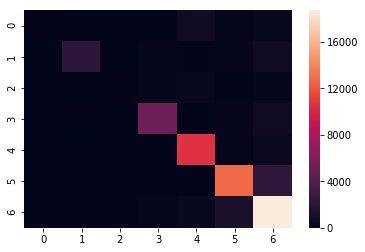

In [56]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import seaborn

seaborn.heatmap(sklearn.metrics.confusion_matrix(y_test_text, tfidf_pred))

## Часть 2. Логистическая регрессия.
[3 балла]

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [57]:
train = pd.read_csv('train.csv')

In [58]:
train.head()


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [59]:
train.price_range.unique()

array([1, 2, 3, 0], dtype=int64)

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.
​
Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [60]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train.loc[train.price_range <= 1, 'price_range'] = 0
train.loc[train.price_range > 1, 'price_range'] = 1


In [61]:
y = train.iloc[:, -1]
X = train.iloc[:, :-1]

Разделите выборку на обучающую и тестовую части в соотношении 70:30. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [62]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [63]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)


Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?
Не забывайте, что метод predict_proba вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [64]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
clf = lr.fit(X_train, y_train)
train_pred = lr.predict_proba(X_test)

threshold = 0.5
y_score = (train_pred[:,1]>=threshold).astype('int')

#y_score = [train_pred[i][1] for i in range(train_pred.shape[0])]
roc_auc = roc_auc_score(y_test, y_score)
accuracy = accuracy_score(y_test, y_score)

In [75]:
print('roc_auc: {}%\naccuracy: {} % '.format(roc_auc*100, accuracy*100))

roc_auc: 98.67653432009868%
accuracy: 98.66666666666667 % 


У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
raw_pred = lr.intercept_ + np.dot(X_test, lr.coef_.transpose())
raw_pred.shape
#plt.hist(raw_pred)

(600, 1)

(array([14., 46., 83., 63., 96., 80., 75., 73., 50., 20.]),
 array([-19.8827584 , -15.91402826, -11.94529811,  -7.97656797,
         -4.00783783,  -0.03910769,   3.92962246,   7.8983526 ,
         11.86708274,  15.83581289,  19.80454303]),
 <a list of 10 Patch objects>)

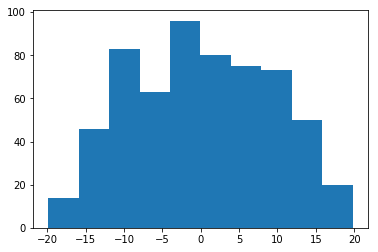

In [68]:
plt.hist(raw_pred)

* Какие значения принимает такое предсказание?
* Похожи ли эти значения на вероятность классов?

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

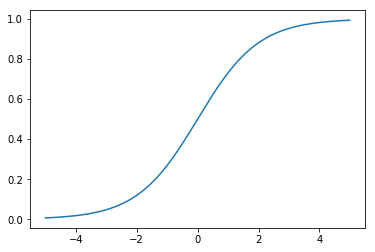

In [70]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
line = np.arange(-5, 5, 0.01)
p = (1 / (1 + np.exp(-line)))
plt.plot(line, p)

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [72]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
p_bx = (1 / (1 + np.exp(raw_pred)))
#print(train_pred[:, 0], p_bx)

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

fpr: [0.         0.         0.003367   0.003367   0.01010101 0.01010101
 0.02020202 0.02020202 1.        ]
 tpr: [0.00330033 0.97359736 0.97359736 0.98679868 0.98679868 0.99339934
 0.99339934 1.         1.        ]
 thresholds: [9.99999997e-01 5.52958004e-01 5.26051154e-01 4.87409849e-01
 4.52227190e-01 4.49247309e-01 3.44695881e-01 3.29214473e-01
 2.31754268e-09]


Text(0.5,1,'ROC-curve')

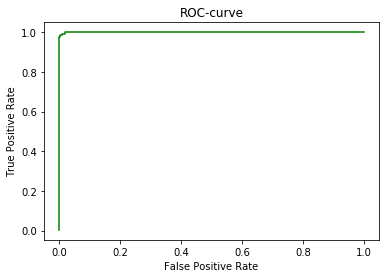

In [73]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test, train_pred[:, 1])
print('fpr: {}\n tpr: {}\n thresholds: {}'.format(fpr, tpr, thresholds))
plt.plot(fpr, tpr, 'g')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-curve')

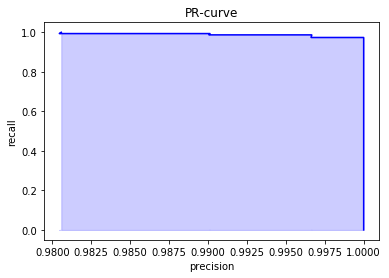

In [74]:
precision, recall, thresholds = precision_recall_curve(y_test, train_pred[:, 1])
plt.plot(precision, recall, 'b')
plt.ylabel('recall')
plt.xlabel('precision')
plt.title('PR-curve')
plt.fill_between(precision, recall, color='blue', alpha=0.2)

### 4. Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$



Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.
Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.
Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково.

В качестве критерия останова необходимо использовать (одновременно):

- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В loss_history необходимо сохранять вычисленное на каждой итерации значение функции потерь.

In [ ]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        pass
        
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        pass
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        pass

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        pass

- Примените логистическую регресиию на той же выборке.
- Посчитайте качество по тем же метрикам.
- Визуализируйте изменение значений функции потерь от номера итераций.